simulate the two player farm game

first, set up big config dictionary that specifies the game to be played

jan 2023


In [1]:
# imports
from random import randint
import numpy as np
import random
import datetime # for limiting calculation to wall clock time
import math
import copy
import matplotlib.pyplot as plt
import csv
import sys

import farmgame
from mcts import MCTS
from agents import RandomPolicy


In [2]:
# practice randomly selecting an action from the legal list and then taking it
TheFarm = farmgame.configure_game(layer="Items00",resourceCond="even",costCond="low",visibilityCond="full",redFirst=True)
state = TheFarm

done=False

while not done:
# for i in range(15):
    currentplayer = state.players[state.turn]
    print(currentplayer['name'] + "'s turn!")
    # print("current backpack: " + str(list(v['name'] for v in currentplayer['backpack']['contents'])))
    # print("current farm items: " + str(list(v['name'] for v in state.items)))
    # print("current farm items: " + str(list(v['status'] for v in state.items)))
    actions = state.legal_actions()
    if actions==[]:
        action=None
        print(currentplayer['name'] + " passes turn. ")
    else:
        print(list(a.id for a in actions))
        action = random.choice(actions) #actions[0]
        print(currentplayer['name'] + " player picks " + action.name)
    state = state.take_action(action,inplace=True) #pick first veg in list
    rwd, done = state.reward(currentplayer['name'])

print("Red Reward: ",state.reward('red'))
print("Purp Reward: ",state.reward('purple'))
    


# action=random.choice(actions)
# print(action.name)
# new_state = state.take_action(action)
# rwd, done = new_state.reward()
# print(rwd, done)
# new_state

red's turn!
['Tomato00', 'Turnip01', 'Turnip00', 'Strawberry01', 'Strawberry00', 'Eggplant00', 'Tomato01', 'Turnip02', 'redpillow']
red player picks eggplant
purple's turn!
['Tomato00', 'Turnip01', 'Turnip00', 'Strawberry01', 'Strawberry00', 'Tomato01', 'Turnip02', 'purplepillow']
purple player picks strawberry
red's turn!
['Tomato00', 'Turnip01', 'Turnip00', 'Strawberry01', 'Tomato01', 'Turnip02', 'box', 'redpillow']
red player picks pillow
purple's turn!
['Tomato00', 'Turnip01', 'Turnip00', 'Strawberry01', 'Tomato01', 'Turnip02', 'box', 'purplepillow']
purple player picks turnip
red's turn!
['Tomato00', 'Turnip01', 'Turnip00', 'Strawberry01', 'Tomato01', 'box', 'redpillow']
red player picks tomato
purple's turn!
['Tomato00', 'Turnip01', 'Turnip00', 'Strawberry01', 'box', 'purplepillow']
purple player picks pillow
red's turn!
['Tomato00', 'Turnip01', 'Turnip00', 'Strawberry01', 'box', 'redpillow']
red player picks pillow
purple's turn!
['Tomato00', 'Turnip01', 'Turnip00', 'Strawberry0

In [3]:
# Creating a game from start
farm_config = farmgame.configure_game(layer="Items00",resourceCond="even",costCond="low",visibilityCond="full",redFirst=True)
done = False

# red
red_agent = MCTS(time=2., C=2, max_moves = 10, color="red")
# red_agent = RandomPolicy(game)
# purple
purp_agent = MCTS(time=2., C=2, max_moves = 10, color="purple")
# purp_agent = RandomPolicy(game)

action_seq = []
state = farm_config
# print("current farm items: " + str(list(v.name for v in state.items if v.status=="farm")))
# print("current box: " + str(list(v.name for v in state.farmbox.contents)))

while not done:

    red_agent.update(state) 
    purp_agent.update(state)

    currentplayer = state.players[state.turn]
    print(currentplayer['name'] + "'s turn!")
    print("current backpack: " + str(list(v.name for v in currentplayer['backpack']['contents'])))
    print("current farm items: " + str(list(v.name for v in state.items)))
    print("current box: " + str(list(v.name for v in state.farmbox.contents)))

    if currentplayer['name'] == "red":
        action = red_agent.choose_action()
    else:
        action = purp_agent.choose_action()

    # actions = state.legal_actions(currentplayer)
    # print(list(a.name for a in actions))
    # action = actions[0]
    if action is None:
        print("THIS SHOULdn't happen")
        print(currentplayer['name'] + " has no more moves.")
    else:
        print(currentplayer['name'] + " player picks " + action.name)

    state = state.take_action(action,inplace=True) #pick first veg in list
    rwd, done = state.reward(currentplayer['name'])


print("Red Reward: ",state.reward('red')[0])
print("Purp Reward: ",state.reward('purple')[0])


red's turn!
current backpack: []
current farm items: ['tomato', 'turnip', 'turnip', 'strawberry', 'strawberry', 'eggplant', 'tomato', 'turnip']
current box: []
red player picks tomato
purple's turn!
current backpack: []
current farm items: ['tomato', 'turnip', 'turnip', 'strawberry', 'strawberry', 'eggplant', 'tomato', 'turnip']
current box: []
purple player picks turnip
red's turn!
current backpack: ['tomato']
current farm items: ['tomato', 'turnip', 'turnip', 'strawberry', 'strawberry', 'eggplant', 'tomato', 'turnip']
current box: []
red player picks strawberry
purple's turn!
current backpack: ['turnip']
current farm items: ['tomato', 'turnip', 'turnip', 'strawberry', 'strawberry', 'eggplant', 'tomato', 'turnip']
current box: []
purple player picks turnip
red's turn!
current backpack: ['tomato', 'strawberry']
current farm items: ['tomato', 'turnip', 'turnip', 'strawberry', 'strawberry', 'eggplant', 'tomato', 'turnip']
current box: []
red player picks turnip
purple's turn!
current bac

In [ ]:
# compare random - random, mcts - random, random - mcts, mcts-mcts

games = [{"red_agent": RandomPolicy(),"purp_agent": RandomPolicy()},
        {"red_agent": MCTS(time=5., C=2, max_moves = 10),"purp_agent": RandomPolicy()},
        {"red_agent": RandomPolicy(),"purp_agent": MCTS(time=5., C=2, max_moves = 10)},
        {"red_agent": MCTS(time=5., C=2, max_moves = 10),"purp_agent": MCTS(time=5., C=2, max_moves = 10)},]
rwds = []

for i in range(len(games)):
    print("GAME "+str(i))
    action_seq = []
    state = farmgame.configure_game() # DEFAULT GAME
    done = False

    red_agent = games[i]["red_agent"]
    purp_agent = games[i]["purp_agent"]
    
    while not done:

        red_agent.update(state) 
        purp_agent.update(state)

        currentplayer = state.players[state.turn]
        # print(currentplayer['name'] + "'s turn!")
        # print("current backpack: " + str(list(v['name'] for v in currentplayer['backpack']['contents'])))
        # print("current farm items: " + str(list(v['name'] for v in state.items)))
        # print("current box: " + str(list(v['name'] for v in state.farmbox['contents'])))

        if currentplayer['name'] == "red":
            action = red_agent.choose_action()
        else:
            action = purp_agent.choose_action()

        # actions = state.legal_actions(currentplayer)
        # print(list(a.name for a in actions))
        # action = actions[0]
        if action is None:
            print("THIS SHOULdn't happen")
            print(currentplayer['name'] + " has no more moves.")
        else:
            print(currentplayer['name'] + " player picks " + action.name)

        state = state.take_action(action,inplace=True) #pick first veg in list
        rwd, done = state.reward(currentplayer['name'])

    print("Red Reward: ",state.reward('red')[0])
    print("Purp Reward: ",state.reward('purple')[0])
    rwds.append({"red":state.reward('red')[0],"purple":state.reward('purple')[0]})
    

GAME 0
red player picks strawberry
purple player picks turnip
red player picks eggplant
purple player picks tomato
red player picks turnip
purple player picks tomato
red player picks strawberry
purple player picks pillow
red player picks pillow
purple player picks turnip
red player picks pillow
purple player picks pillow
red player picks box
purple player picks pillow
red player picks none
purple player picks pillow
red player picks none
purple player picks box
Red Reward:  156
Purp Reward:  128
GAME 1
red player picks strawberry
purple player picks pillow
red player picks turnip
purple player picks turnip
red player picks tomato
purple player picks tomato
red player picks strawberry
purple player picks turnip
red player picks box
purple player picks eggplant
red player picks none
purple player picks box
Red Reward:  188
Purp Reward:  188
GAME 2
red player picks strawberry
purple player picks tomato
red player picks pillow
purple player picks turnip
red player picks tomato
purple playe

In [26]:

# now let's compare the performance of different C

storestates = []
storeactions = []
storerewards_red = []
storerewards_purp = []
cs = [8,10,25,50,100,150]

n_reps = 10
all_rwds_c_r = []
all_rwds_c_p = []

for c in cs:
    print("C = ", c)
    storerewards_red = []
    storerewards_purp = []

    for i in range(n_reps):
    
        state = farmgame.configure_game(layer="Items00",resourceCond="even",costCond="low",visibilityCond="full",redFirst=True)
        done = False

        # red
        red_agent = MCTS(time=5., C=c, max_moves = 10, color="red") #, verbose=True)

        # purple
        purp_agent = MCTS(time=5., C=c, max_moves = 10, color="purple")

        action_seq = []


        while not done:

            red_agent.update(state) 
            purp_agent.update(state)

            currentplayer = state.players[state.turn]

            if currentplayer['name'] == "red":
                action = red_agent.choose_action()
            else:
                action = purp_agent.choose_action()

            # print(currentplayer['name'] + " player picks " + action['name'])
            
            state = state.take_action(action,inplace=True) #pick first veg in list
            rwd, done = state.reward(currentplayer['name'])

            action_seq.append(action)


        print("Red Reward: ",state.reward('red')[0])
        print("Purp Reward: ",state.reward('purple')[0])
        
        storestates.append([red_agent.states])
        storeactions.append([action_seq])
        storerewards_red.append(state.reward('red')[0])
        storerewards_purp.append(state.reward('purple')[0])

    all_rwds_c_r.append(storerewards_red)
    all_rwds_c_p.append(storerewards_purp)


C =  8
Red Reward:  148
Purp Reward:  168
Red Reward:  104
Purp Reward:  196
Red Reward:  80
Purp Reward:  232
Red Reward:  188
Purp Reward:  248
Red Reward:  160
Purp Reward:  236
Red Reward:  236
Purp Reward:  208
Red Reward:  228
Purp Reward:  240
Red Reward:  152
Purp Reward:  236
Red Reward:  236
Purp Reward:  248
Red Reward:  228
Purp Reward:  176
C =  10
Red Reward:  228
Purp Reward:  264
Red Reward:  204
Purp Reward:  152
Red Reward:  228
Purp Reward:  256
Red Reward:  220
Purp Reward:  208
Red Reward:  204
Purp Reward:  256
Red Reward:  236
Purp Reward:  208
Red Reward:  192
Purp Reward:  160
Red Reward:  244
Purp Reward:  172
Red Reward:  268
Purp Reward:  288
Red Reward:  196
Purp Reward:  176
C =  25
Red Reward:  204
Purp Reward:  208
Red Reward:  236
Purp Reward:  216
Red Reward:  220
Purp Reward:  224
Red Reward:  116
Purp Reward:  204
Red Reward:  156
Purp Reward:  256
Red Reward:  208
Purp Reward:  156
Red Reward:  228
Purp Reward:  204
Red Reward:  228
Purp Reward:  22

ValueError: x and y must have same first dimension, but have shapes (6,) and (1,)

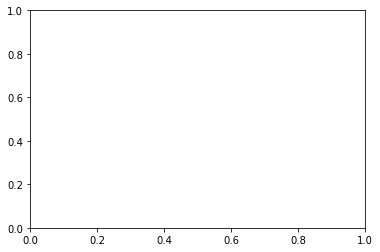

In [27]:
# cashmoney_r = [i for (i,a) in storerewards_red]
# cashmoney_p = [i for (i,a) in storerewards_purp]

# plt.plot(cs,storerewards_red,'o-',color="red")
# plt.plot(cs,storerewards_purp,'o-',color="purple")

plt.plot(cs,np.mean(all_rwds_c_r),yerr=np.std(all_rwds_c_r),color="red")
plt.plot(cs,np.mean(all_rwds_c_p),yerr=np.std(all_rwds_c_p),color="purple")
plt.xlabel("C")
plt.ylabel("reward")
plt.show()

In [10]:
# now let's compare the performance of different computation times

storetstates = []
storetactions = []

# 1min, 2min, 3min, 4min, 5min, 6min per game approx
times = [0.1,0.5,1,2,5,10,15,20,25,30]

# set c as desired
c=100

# 10*(1 + 2 + 3 + 4 + 5 + 6) = 210 min approx (~3.5 hours)
n_reps = 10
all_rwds_r = []
all_rwds_p = []

for t in times:
    print("Computation time = ", t)
    storetrewards_red = []
    storetrewards_purp = []

    for i in range(n_reps):

        # Initialize the tamagotchi
        state = farmgame.configure_game(layer="Items00",resourceCond="even",costCond="low",visibilityCond="full",redFirst=True)
        done = False

         # red
        red_agent = MCTS(time=t, C=c, max_moves = 10, color="red")

        # purple
        purp_agent = MCTS(time=t, C=c, max_moves = 10, color="purple")

        action_seq = []
        
        while not done:
            red_agent.update(state) 
            purp_agent.update(state)

            currentplayer = state.players[state.turn]

            if currentplayer['name'] == "red":
                action = red_agent.choose_action()
            else:
                action = purp_agent.choose_action()
            
            state = state.take_action(action,inplace=True) #pick first veg in list
            rwd, done = state.reward(currentplayer['name'])

            action_seq.append(action)

        print("Red Reward: ",state.reward('red')[0])
        print("Purp Reward: ",state.reward('purple')[0])
        
        storetstates.append([red_agent.states])
        storetactions.append([action_seq])
        storetrewards_red.append(state.reward('red')[0])
        storetrewards_purp.append(state.reward('purple')[0])

    all_rwds_r.append(storetrewards_red)
    all_rwds_p.append(storetrewards_purp)

Computation time =  0.1
Red Reward:  96
Purp Reward:  76
Red Reward:  76
Purp Reward:  124
Red Reward:  108
Purp Reward:  212
Red Reward:  144
Purp Reward:  188
Red Reward:  48
Purp Reward:  64
Red Reward:  0
Purp Reward:  100
Red Reward:  104
Purp Reward:  120
Red Reward:  116
Purp Reward:  136
Red Reward:  156
Purp Reward:  176
Red Reward:  136
Purp Reward:  168
Computation time =  0.5
Red Reward:  196
Purp Reward:  168
Red Reward:  176
Purp Reward:  208
Red Reward:  136
Purp Reward:  112
Red Reward:  224
Purp Reward:  168
Red Reward:  208
Purp Reward:  176
Red Reward:  176
Purp Reward:  208
Red Reward:  104
Purp Reward:  168
Red Reward:  200
Purp Reward:  216
Red Reward:  144
Purp Reward:  168
Red Reward:  196
Purp Reward:  208
Computation time =  1
Red Reward:  164
Purp Reward:  168
Red Reward:  216
Purp Reward:  136
Red Reward:  200
Purp Reward:  184
Red Reward:  216
Purp Reward:  208
Red Reward:  116
Purp Reward:  116
Red Reward:  144
Purp Reward:  140
Red Reward:  104
Purp Rewar

In [20]:
print(all_rwds_r)
print(np.shape(all_rwds_r))
np.mean(all_rwds_r,axis=1)

[[96, 76, 108, 144, 48, 0, 104, 116, 156, 136], [196, 176, 136, 224, 208, 176, 104, 200, 144, 196], [164, 216, 200, 216, 116, 144, 104, 196, 188, 124], [192, 228, 200, 188, 180, 208, 184, 148, 224, 188], [208, 196, 208, 228, 248, 208, 184, 208, 236, 88], [248, 176, 264, 136, 176, 216, 216, 184, 216, 216], [176, 168, 208, 216, 224, 224, 200, 176, 216, 208], [168, 216, 248, 216, 164, 168, 208, 216, 232, 208], [168, 200, 124, 216, 248, 208, 256, 256, 208, 176], [216, 224, 256, 256, 248, 208, 248, 208, 216, 208]]
(10, 10)


array([ 98.4, 176. , 166.8, 194. , 201.2, 204.8, 201.6, 204.4, 206. ,
       228.8])

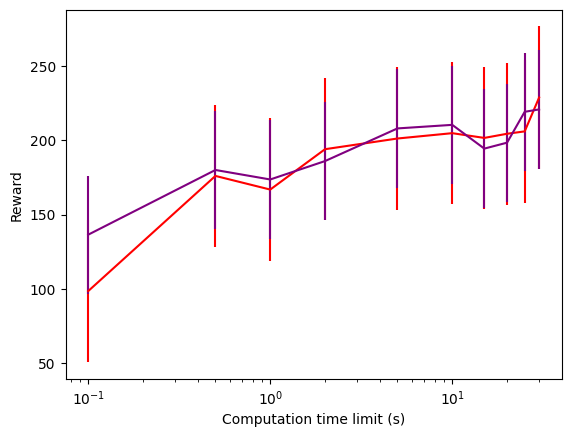

In [26]:
# plot rwd vs comp time

plt.errorbar(times,np.mean(all_rwds_r,axis=1),yerr=np.std(all_rwds_r),color="red")
plt.errorbar(times,np.mean(all_rwds_p,axis=1),yerr=np.std(all_rwds_p),color="purple")
plt.xlabel("Computation time limit (s)")
plt.ylabel("Reward")
plt.xscale('log')
plt.show()

In [ ]:
storelstates = []
storelactions = []
storelrewards_red = []
storelrewards_purp = []
layers = ["Items00","Items01","Items02","Items03","Items04","Items05","Items06","Items07","Items08","Items09","Items10","Items11"]

for l in layers:
    print("Layer = ", l)
    
    # Initialize the tamagotchi
    state = configure_game(layer = l)
    game = farmgame.FarmGame()
    done = False

    # red
    red_agent = MCTS(game, time=2., C=1, max_moves = 20)

    # purple
    purp_agent = MCTS(game, time=2., C=1, max_moves = 20)

    action_seq = []
    
    while not done:
        red_agent.update(state) 
        purp_agent.update(state)

        currentplayer = state.players[state.turn]
        # print("*** " + currentplayer.name + "'s turn! ***")
        # print("current farm items: " + str(list(v.name for v in state.items if v.status=="farm")))
        # print("current backpack: " + str(list(v.name for v in currentplayer.backpack.contents)))
        # print("current box: " + str(list(v.name for v in state.farmbox.contents)))

        if currentplayer.name == "red":
            action = red_agent.choose_action()
        else:
            action = purp_agent.choose_action()

        action_seq.append(action)

        if action is None:
            print(currentplayer.name + " has no more moves.")
        else:
            print(currentplayer.name + " player picks " + action.name)
        state = state.take_action(action,inplace=True) #pick first veg in list
        rwd, done = state.reward(currentplayer.name)

    print("Red Reward: ",game.reward(red_agent.states,'red'))
    print("Purp Reward: ",game.reward(purp_agent.states,'purple'))
    
    storelstates.append([red_agent.states])
    storelactions.append([action_seq])
    storelrewards_red.append(game.reward(red_agent.states,'red'))
    storelrewards_purp.append(game.reward(purp_agent.states,'purple'))

Layer =  Items00
red player picks tomato
purple player picks turnip
red player picks turnip
purple player picks strawberry
red player picks strawberry
purple player picks eggplant
red player picks tomato
purple player picks turnip
red player picks box
purple player picks box
Red Reward:  (176, True)
Purp Reward:  (184, True)
Layer =  Items01
red player picks tomato
purple player picks turnip
red player picks turnip
purple player picks strawberry
red player picks strawberry
purple player picks eggplant
red player picks tomato
purple player picks turnip
red player picks box
purple player picks box
Red Reward:  (216, True)
Purp Reward:  (192, True)
Layer =  Items02
red player picks tomato
purple player picks turnip
red player picks turnip
purple player picks strawberry
red player picks strawberry
purple player picks strawberry
red player picks eggplant
purple player picks tomato
red player picks box
purple player picks box
Red Reward:  (180, True)
Purp Reward:  (162, True)
Layer =  Items0

In [ ]:
print(storelrewards_red)
print(storelrewards_purp)

[(176, True), (216, True), (180, True), (162, True), (14, True), (42, True), (168, True), (232, True), (168, True), (270, True), (14, True), (14, True)]
[(184, True), (192, True), (162, True), (220, True), (0, True), (0, True), (168, True), (168, True), (270, True), (156, True), (0, True), (0, True)]
